In [1]:
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime, timedelta

In [2]:
%matplotlib inline

# Module 15 Lab - Time Series

## Directions


The due dates for each are indicated in the Syllabus and the course calendar. If anything is unclear, please email EN685.648@gmail.com the official email for the course or ask questions in the Lab discussion area on Canvs.

The Labs also present technical material that augments the lectures and "book".  You should read through the entire lab at the start of each module.

<div style="background: mistyrose; color: firebrick; border: 2px solid darkred; padding: 5px; margin: 10px;">
Please follow the directions and make sure you provide the requested output. Failure to do so may result in a lower grade even if the code is correct or even 0 points.
</div>

1. Show all work/steps/calculations using Code and Markdown cells.
2. Submit your notebook (.ipynb).
3. You may use any core Python libraries or Numpy/Scipy. **Additionally, code from the Module notebooks and lectures is fair to use and modify.** You may also consult Stackoverflow (SO). If you use something from SO, please place a comment with the URL to document the code.

In [3]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import random
import patsy
from patsy.highlevel import dmatrices
import sklearn.linear_model as linear

sns.set(style="whitegrid")
# load whatever other libraries you need including models.py

This lab covers time series data.  The exact flow may look a little different from the ETL/EDA/Modeling sequence that we've become familiar with from linear models, but we will follow the same general process.  Complete each of the following according to the course notes in Module 15.

## 1: Load the data, cleaning and transforming if necessary.


In [4]:
df = pd.read_csv('https://raw.githubusercontent.com/fundamentals-of-data-science/datasets/master/timeseries.csv')
# add the rest of your code below here


Let's look at the data

In [5]:
df.head()

,date,value
0,2019-01-01,64.51
1,2019-01-02,1.67
2,2019-01-03,84.41
3,2019-01-04,119.14
4,2019-01-05,20.78


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180 entries, 0 to 179
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    180 non-null    object 
 1   value   180 non-null    float64
dtypes: float64(1), object(1)
memory usage: 2.9+ KB


Only 2 columns with dates and values. We have 180 observations. I'm going to rearrange the time format. Note all the observations have the same year.

In [7]:
days_of_the_week = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

In [8]:
calendar = []

today = datetime(2018, 12, 31, 0, 0)
for _ in range(0, 180):
    today = today + timedelta(days=1)
    date = today.strftime("%m/%d/%y")
    day = days_of_the_week[today.weekday()]
    calendar.append((date, day))

It might be useful to look at the days of the week later. I'll concat them into our dataframe along with just the month and day

In [9]:

dates = pd.Series([i[0][:5] for i in calendar], name='date_trunc')
days = pd.Series([i[1] for i in calendar], name='day')
df = pd.concat([df, dates, days], axis=1)

Here is the adjusted dataframe

In [10]:
df

,date,value,date_trunc,day
0,2019-01-01,64.51,01/01,Tuesday
1,2019-01-02,1.67,01/02,Wednesday
2,2019-01-03,84.41,01/03,Thursday
3,2019-01-04,119.14,01/04,Friday
4,2019-01-05,20.78,01/05,Saturday
...,...,...,...,...
175,2019-06-25,178.84,06/25,Tuesday
176,2019-06-26,354.54,06/26,Wednesday
177,2019-06-27,279.00,06/27,Thursday
178,2019-06-28,286.76,06/28,Friday


Good enough for now. Let's move on to EDA.

## 2: Perform EDA on the time variable and describe what kind of time series (trend, seasonality, etc).

Time is an ordered variable, technically numeric but we wouldn't traditionally perform mathematical operations on time series data.

In [11]:
df['date'].describe()

count            180
unique           180
top       2019-01-01
freq               1
Name: date, dtype: object

Here are the head and tail of the dataframe once again

In [12]:
df

,date,value,date_trunc,day
0,2019-01-01,64.51,01/01,Tuesday
1,2019-01-02,1.67,01/02,Wednesday
2,2019-01-03,84.41,01/03,Thursday
3,2019-01-04,119.14,01/04,Friday
4,2019-01-05,20.78,01/05,Saturday
...,...,...,...,...
175,2019-06-25,178.84,06/25,Tuesday
176,2019-06-26,354.54,06/26,Wednesday
177,2019-06-27,279.00,06/27,Thursday
178,2019-06-28,286.76,06/28,Friday


As such, we can't really get a mean, median, or other usual summary statistics.

We see the date ranges we have are from Jan 1st 2019 to Jun 29th 2019, the first half of the year. Let's plot it to see what values we get for each date.

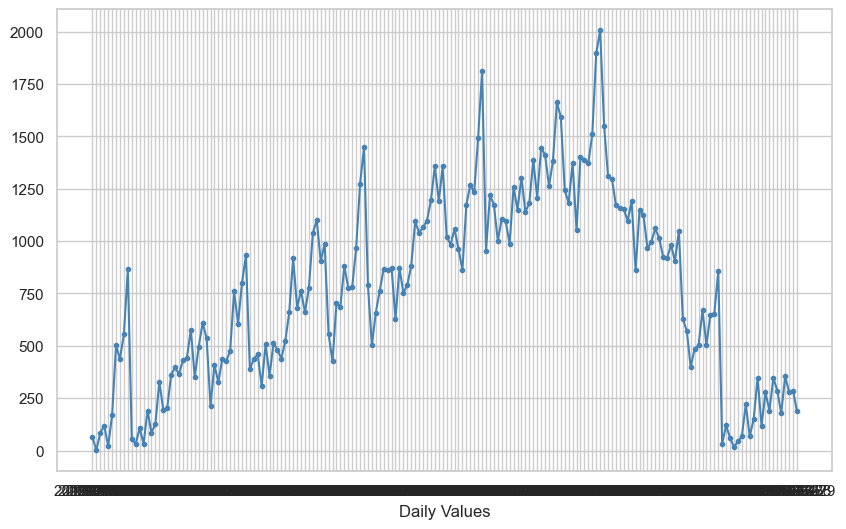

In [13]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)

axes.plot(df["date"], df[ "value"], color="steelblue", marker=".")
axes.set_xlabel("Daily Values")

plt.show()

We definitely see a pattern here, we steadily increase until about 75% through the data, then start decreasing. Here is another plot only showing by month, which might be easier to read:

In [14]:
import matplotlib.dates as mdates

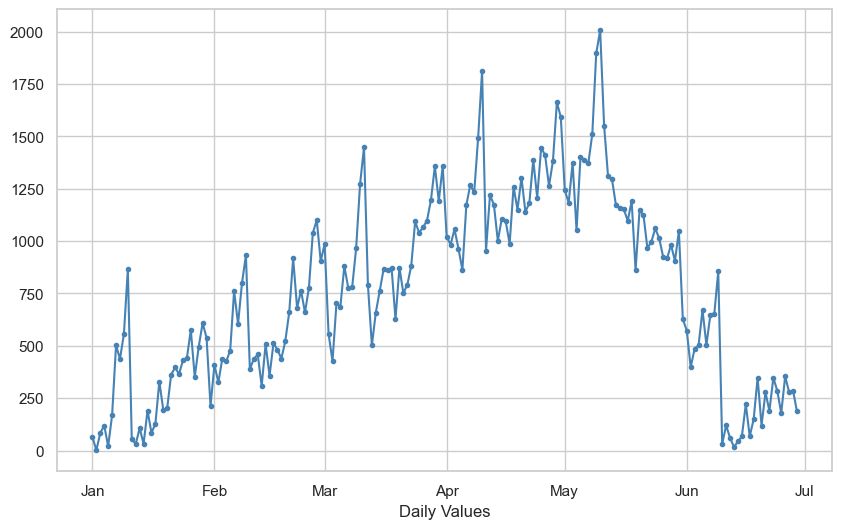

In [15]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)

axes.xaxis.set_major_locator(mdates.MonthLocator())
fmt = mdates.DateFormatter('%b')
axes.xaxis.set_major_formatter(fmt)

axes.plot(df["date"], df[ "value"], color="steelblue", marker=".")
axes.set_xlabel("Daily Values")

plt.show()

A bit better. We see that values increase until beginning of May, then decrease afterwards, and rise a bit in Jun as well, following a sharp drop.

I'll consider this good enough for the purposes of our EDA. Let's move on to creating the models in the next step.

## 3: Create models with each of Simple Exponential Smoothing, Holts Trend Correction and Holts Winters Seasonality Adjustment. Choose an error (SSE, etc) and compare the three models. How are they different, and why?

We'll start with simple exponential smoothing. I'll take the average of the first 10 points since our data is fairly noisy. I'll start with an $\alpha$ of 0.5.

In [16]:
df['t'] = pd.Series(range(1, 181))

In [17]:
alpha = 0.5

n = len(df['value'])
level = df['value'][0:10].mean()
ses = [level]
for i in range(1, n):
    level = level + alpha * (df['value'][i-1] - level)
    ses.append(level)

Let's look at a plot again compared to the original data

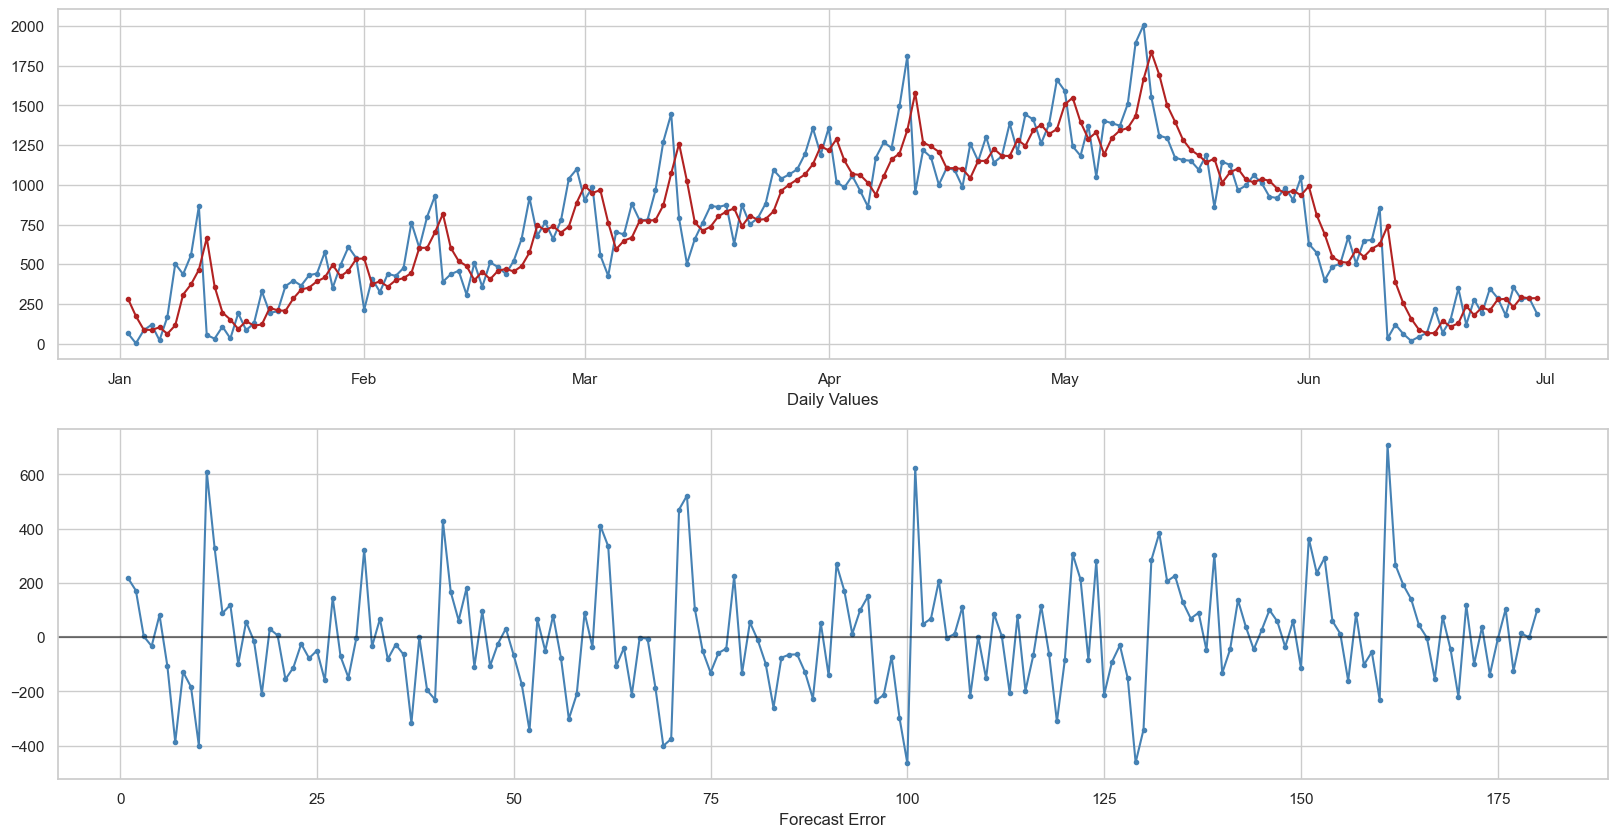

In [18]:
df['ses'] = pd.Series(ses)

figure = plt.figure(figsize=(20, 10))

axes = figure.add_subplot(2, 1, 1)

axes.xaxis.set_major_locator(mdates.MonthLocator())
fmt = mdates.DateFormatter('%b')
axes.xaxis.set_major_formatter(fmt)

axes.plot( df["t"], df[ "value"], color="steelblue", marker=".")
axes.plot( df["t"], df[ "ses"], color="firebrick", marker=".")
axes.set_xlabel( "Daily Values")

axes = figure.add_subplot(2, 1, 2)

axes.plot( df["t"], df[ "ses"] - df[ "value"], color="steelblue", marker=".")
axes.axhline(y=0.0, xmin=0, xmax=40, c="black", alpha=0.5)
axes.set_xlabel( "Forecast Error")

plt.show()

Here we can see the smoothing from ses. The forecast errors seem to exhibit somewhat of a cyclic pattern, but no major upward/downward trends.

Now let's do Holts Trend Correction. 

In [19]:
def lm( formula, data=None):
    if data is None:
        raise ValueError( "The parameter 'data' must be assigned a non-nil reference to a Pandas DataFrame")

    result = {}
    result[ "formula"] = formula
    result[ "n"] = data.shape[ 0]

    y, X = dmatrices( formula, data, return_type="matrix")
    model = linear.LinearRegression( fit_intercept=False).fit( X, y)

    result[ "coefficients"] = model.coef_[ 0]

    result[ "r^2"] = model.score( X, y)
    
    y_hat = model.predict( X)
    result[ "residuals"] = y - y_hat
    
    sum_squared_error = sum([ e**2 for e in result[ "residuals"]])[ 0]

    n = len( result[ "residuals"])
    k = len( result[ "coefficients"])
    
    result[ "sigma"] = np.sqrt( sum_squared_error / (n - k))
    
    return result

In [20]:
def describe_fit( result):
    formula = result[ "formula"]
    print("regression: ", formula)
    print("n: ", result[ "n"])
    print("----------")
    variables = formula.split("~")[1].split( "+")
    variables = ["intercept"] + variables
    coefficients = result[ "coefficients"]
    for variable, coefficient in zip( variables, coefficients):
        print(variable.strip() + ": ", coefficient)
    print("----------")
    print("sigma", result[ "sigma"])
    print("R^2", result[ "r^2"])

In [21]:
def holts_one_step( alpha, gamma, level, trend, error):
    this_trend = trend + gamma * alpha * error
    this_level = level + trend + alpha * error
    return (this_trend, this_level)

def holts_forecast( level_0, trend_0, alpha, gamma, actual):
    n = len( actual)
    trend, level = trend_0, level_0
    trends = []
    levels = []
    forecasts = []
    
    for i in range( 0, n):
        forecast = level + trend
        forecasts.append( forecast)
        
        error = actual[ i] - forecast

        trend, level = holts_one_step( alpha, gamma, level, trend, error)
        
        trends.append( trend)
        levels.append( level)

    return (pd.Series( forecasts), pd.Series( levels), pd.Series( trends))

We start by regressing time as our independent variable and values as our dependent variable in order to find an intercept/starting level.

In [22]:
describe_fit(lm('value ~ t', data=df.loc[0:30]))

regression:  value ~ t
n:  31
----------
intercept:  114.38516129032266
t:  10.908427419354837
----------
sigma 198.86938888826222
R^2 0.20464574007030012


We see intercept of 114.39 and slope of 10.9084. Now for the smoothing.

In [23]:
holts, levels, trends = holts_forecast(114.39, 10.9084, 0.5, 0.5, df[ "value"])

Now let's plot again

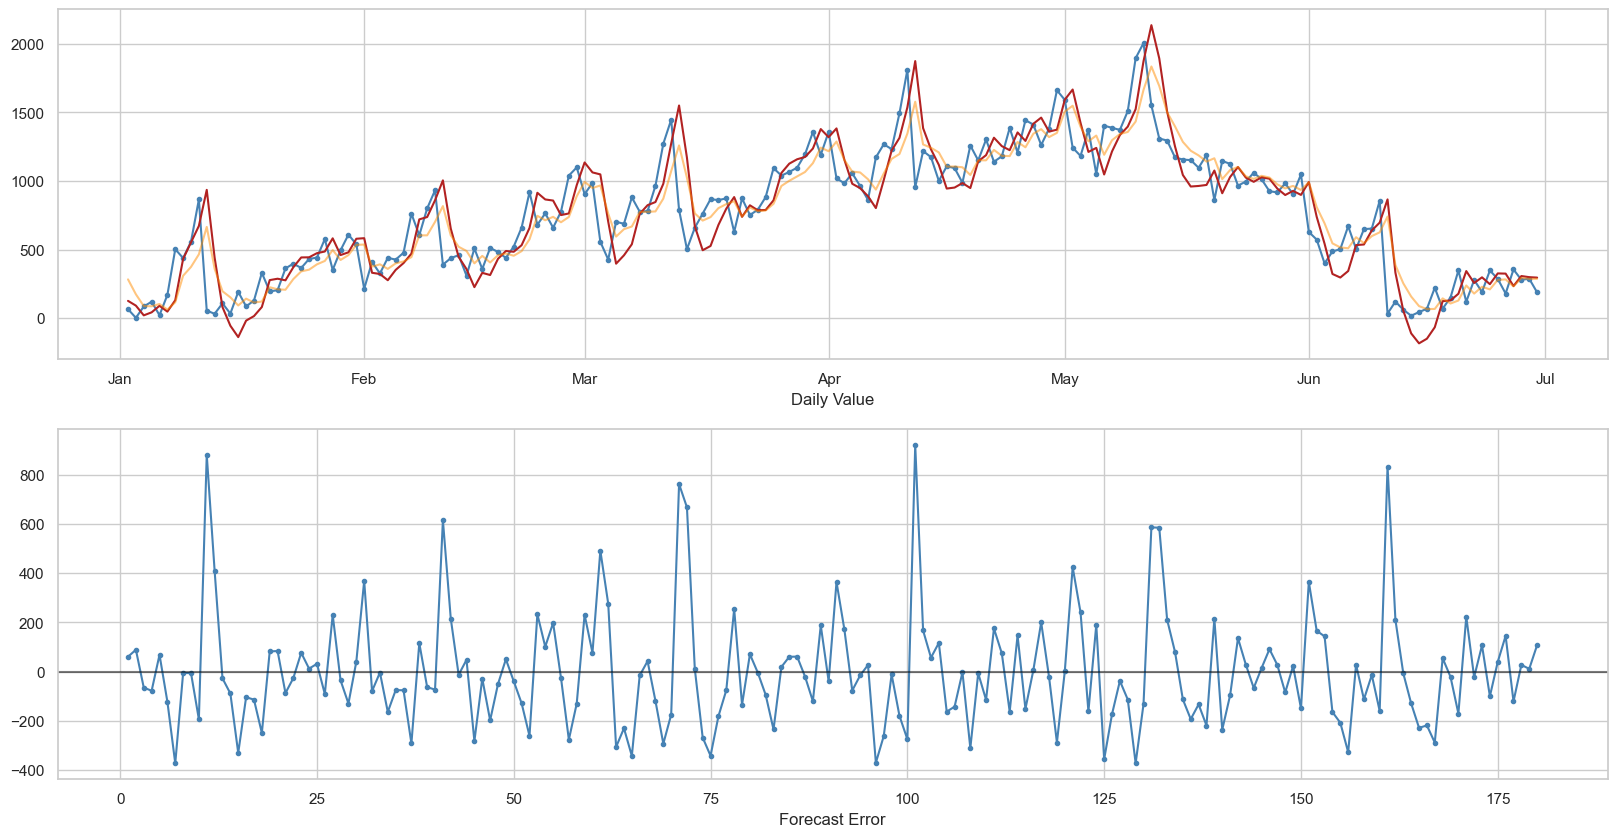

In [24]:
df[ "holts"] = holts
df[ "holts_level"] = levels
df[ "holts_trend"] = trends

figure = plt.figure(figsize=(20, 10))

axes = figure.add_subplot(2, 1, 1)

axes.xaxis.set_major_locator(mdates.MonthLocator())
fmt = mdates.DateFormatter('%b')
axes.xaxis.set_major_formatter(fmt)

axes.plot( df["t"], df[ "value"], color="steelblue", marker=".")
axes.plot( df["t"], df[ "holts"], color="firebrick")
axes.plot( df["t"], df[ "ses"], color="darkorange", alpha=0.5)
axes.set_xlabel( "Daily Value")

axes = figure.add_subplot(2, 1, 2)

axes.plot(df["t"], df[ "holts"] - df[ "value"], color="steelblue", marker=".")
axes.axhline(y=0.0, xmin=0, xmax=40, c="black", alpha=0.5)
axes.set_xlabel( "Forecast Error")

plt.show()

Very interesting. I think the forecast error is slightly higher than with ses. 

Finally let's create a model for Holts-Winters which includes seasonality. We start with finding moving averages. Let's use 15 days as our window (basically half a month).

In [25]:
ma_sales = df['value'].rolling(window=15, center=True).mean()

shifted_ma = []
for i in range(0, 181):
    current = None
    if 7 < i < 172:
        current = df["value"][ i-7:i+8].mean()
    shifted_ma.append( current)
shifted_ma_sales = pd.Series( shifted_ma)

In [26]:
smoothed_sales = (ma_sales + shifted_ma_sales) / 2.0
smoothed_sales[172] = None

seasonal_factor_estimate = df[ "value"] / smoothed_sales
seasonal_factor_estimate[0:30]

0          NaN
1          NaN
2          NaN
3          NaN
4          NaN
5          NaN
6          NaN
7          NaN
8     2.564082
9     3.836202
10    0.224706
11    0.126020
12    0.412970
13    0.119562
14    0.721087
15    0.326481
16    0.507409
17    1.474398
18    0.753366
19    0.726282
20    1.185543
21    1.153631
22    0.995783
23    1.147002
24    1.119017
25    1.461702
26    0.855580
27    1.164083
28    1.406158
29    1.176989
dtype: float64

Sure. We have 163 values and need 15, so look for the indices.

In [27]:
initial_seasonal_factors = [
    seasonal_factor_estimate[[0, 16, 32]].mean(),
    seasonal_factor_estimate[[1, 17, 33]].mean(),
    seasonal_factor_estimate[[2, 18, 34]].mean(),
    seasonal_factor_estimate[[3, 19, 35]].mean(),
    seasonal_factor_estimate[[4, 20, 36]].mean(),
    seasonal_factor_estimate[[5, 21, 37]].mean(),
    seasonal_factor_estimate[[6, 22, 38]].mean(),
    seasonal_factor_estimate[[7, 23, 39]].mean(),
    seasonal_factor_estimate[[8, 24, 40]].mean(),
    seasonal_factor_estimate[[9, 25, 41]].mean(),
    seasonal_factor_estimate[[10, 26, 42]].mean(),
    seasonal_factor_estimate[[11, 27, 43]].mean(),
    seasonal_factor_estimate[[12, 28, 44]].mean(),
    seasonal_factor_estimate[[13, 29, 45]].mean(),
    seasonal_factor_estimate[[14, 30, 46]].mean(),
    seasonal_factor_estimate[[15, 31, 47]].mean()
    
    ]
initial_seasonal_factors

[0.560131210756337,
 1.1613958620636133,
 0.7836418600140784,
 0.8202005261131294,
 1.3523946503064268,
 1.1815725377360222,
 1.2837133584355724,
 1.4770485595202205,
 1.4744693521841727,
 2.042819204677536,
 0.647250109293286,
 0.6189842667230683,
 0.9112604117185996,
 0.64502548921687,
 0.6964849330467725,
 0.6806972015789926]

Now to deseasonsalize the data like so

In [28]:
from copy import deepcopy

In [29]:
seasonal_factors = pd.Series( 
                                initial_seasonal_factors 
                                + deepcopy(initial_seasonal_factors) 
                                + deepcopy(initial_seasonal_factors)
                                + deepcopy(initial_seasonal_factors)
                                + deepcopy(initial_seasonal_factors)
                                + deepcopy(initial_seasonal_factors)
                                + deepcopy(initial_seasonal_factors)
                                + deepcopy(initial_seasonal_factors)
                                + deepcopy(initial_seasonal_factors)
                                + deepcopy(initial_seasonal_factors)
                                + deepcopy(initial_seasonal_factors)
                                + deepcopy(initial_seasonal_factors)
                            )

In [30]:
df[ "seasonal"] = seasonal_factors

df[ "deseasonalized"] = df[ "value"] / df[ "seasonal"]
print(df[["value", "deseasonalized"]])

      value  deseasonalized
0     64.51      115.169444
1      1.67        1.437925
2     84.41      107.715022
3    119.14      145.257161
4     20.78       15.365337
..      ...             ...
175  178.84      262.730623
176  354.54      632.958837
177  279.00      240.228168
178  286.76      365.932468
179  187.20      228.236869

[180 rows x 2 columns]


Now we fit the data with trend line

In [31]:
describe_fit( lm( "deseasonalized ~ t", data=df))

regression:  deseasonalized ~ t
n:  180
----------
intercept:  571.384909046989
t:  3.0296928328743227
----------
sigma 588.7420604102006
R^2 0.06742684582273151


We see initial level of 571.38 and slope of 3.0297.

In [32]:
def holt_winters_one_step( alpha, gamma, delta, level, trend, error, factor):
    this_factor = factor + delta * (1.0 - alpha) * error / ( level + trend)
    this_trend = trend + (gamma * alpha * error) / factor
    this_level = level + trend + (alpha * error) / factor
    return (this_factor, this_trend, this_level)

def holt_winters_forecast( level_0, trend_0, alpha, gamma, delta, actual, seasonality):
    n = len( actual)
    trend, level, factor = trend_0, level_0, seasonality[ 0]
    factors = []
    trends = []
    levels = []
    forecasts = []
    
    for i in range( 0, n):
        if i < 12:
            factor = seasonality[ i]
        else:
            factor = factors[ i - 12]

        forecast = (level + trend) * factor
        forecasts.append( forecast)
        
        error = actual[ i] - forecast

        factor, trend, level = holt_winters_one_step( alpha, gamma, delta, level, trend, error, factor)
        
        factors.append( factor)
        trends.append( trend)
        levels.append( level)
        
            
        print(forecast, error, level, trend, factor)

    return (pd.Series( forecasts), pd.Series( levels), pd.Series( trends), pd.Series( factors))

Now we can use our helper functions as found in the module notes.

In [33]:
winters, levels, trends, factors = holt_winters_forecast(571.38, 3.0297, 0.5, 0.5, 0.0, df[ "value"], initial_seasonal_factors)

321.74480073118434 -257.23480073118435 344.78957190193887 -111.78036404903057 0.560131210756337
270.6159298230881 -268.9459298230881 117.22356636404744 -169.673184793461 1.1613958620636133
-41.101716543054316 125.51171654305432 27.632701663083466 -129.63202474721248 0.7836418600140784
-83.65989845678568 202.79989845678568 21.62891903480721 -67.81790368774438 0.8202005261131294
-62.46573574771787 83.24573574771787 -15.411823663407969 -52.42932319297978 1.3523946503064268
-80.15923605402425 248.90923605402423 37.48849990865648 0.23550018954233565 1.1815725377360222
48.42680285968267 454.00319714031735 214.55599851784564 88.65149939936575 1.2837133584355724
447.8521980343474 -10.672198034347389 299.5948211485431 86.8451610150316 1.4770485595202205
569.7939101587892 -12.9539101587892 382.04724584131736 84.64879285390295 1.4744693521841727
953.3756305935265 -88.02563059352644 445.15090381691823 73.87622541475193 2.042819204677536
335.940366121379 -281.580366121379 301.50660503366845 -34.884

In [34]:
df[ "winters"] = winters
df[ "winters_level"] = levels
df[ "winters_trend"] = trends
df[ "winters_factors"] = factors

Finally let's plot it

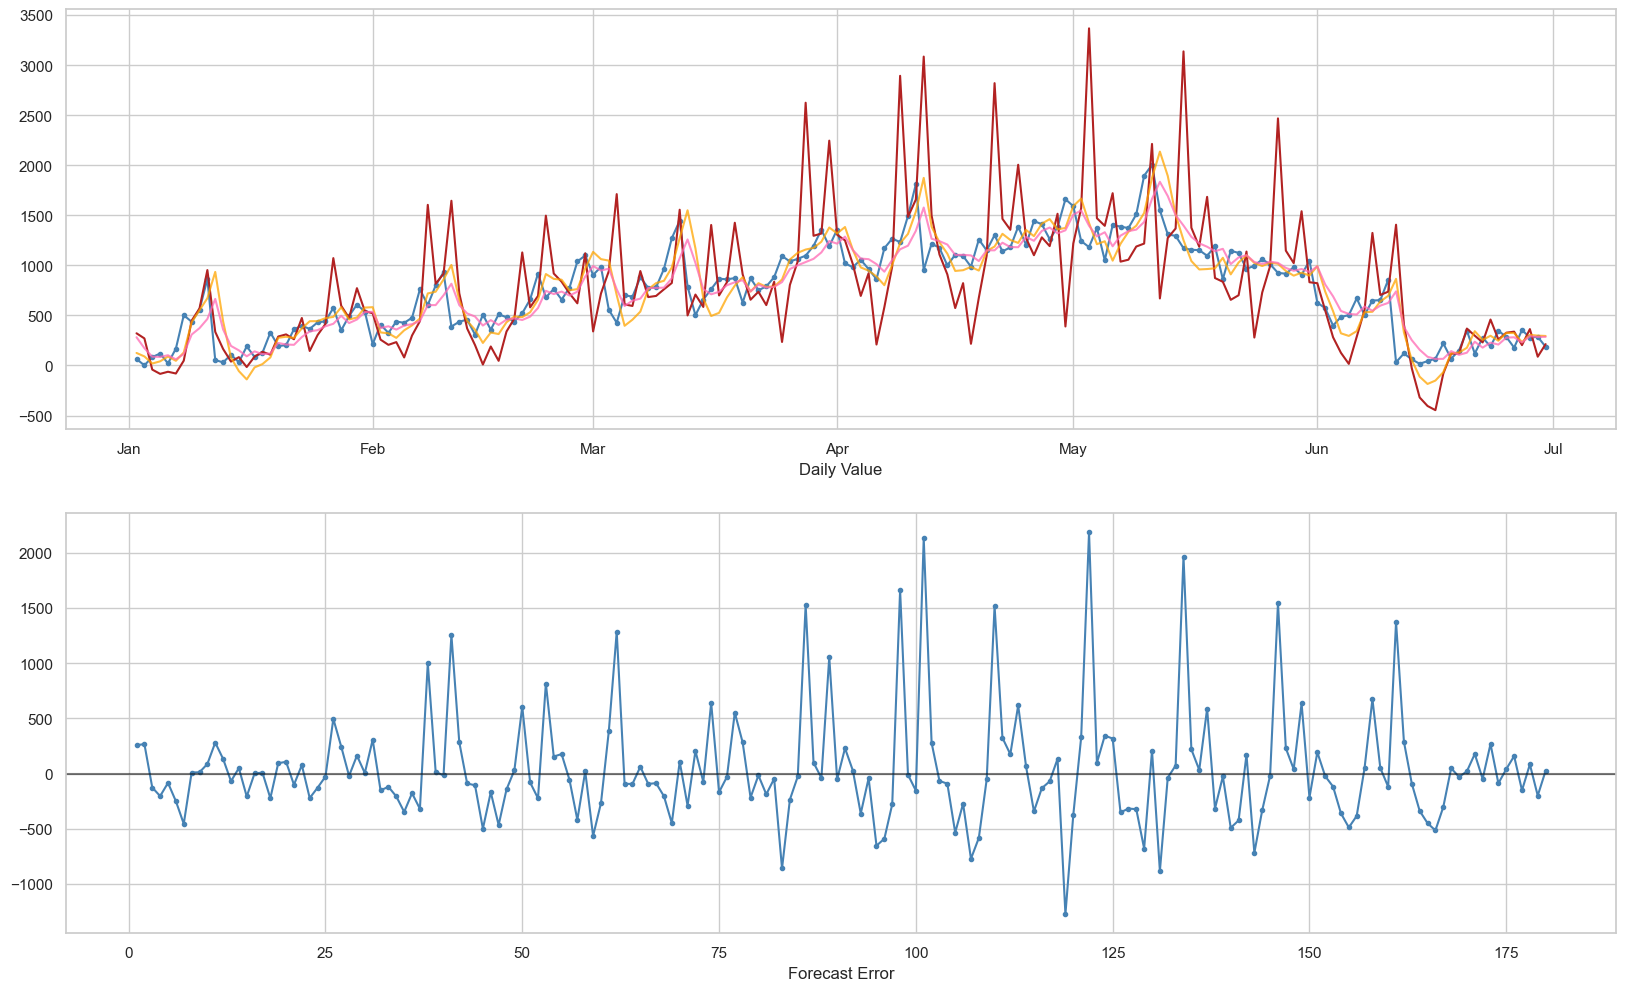

In [35]:
figure = plt.figure(figsize=(20, 12))

axes = figure.add_subplot(2, 1, 1)

axes.xaxis.set_major_locator(mdates.MonthLocator())
fmt = mdates.DateFormatter('%b')
axes.xaxis.set_major_formatter(fmt)

axes.plot( df["t"], df[ "value"], color="steelblue", marker=".")
axes.plot( df["t"], df[ "winters"], color="firebrick")
axes.plot( df["t"], df[ "holts"], color="orange", alpha=0.75)
axes.plot( df["t"], df[ "ses"], color="hotpink", alpha=0.75)
axes.set_xlabel( "Daily Value")

axes = figure.add_subplot(2, 1, 2)

axes.plot( df["t"], df[ "winters"] - df[ "value"], color="steelblue", marker=".")
axes.axhline(y=0.0, xmin=0, xmax=40, c="black", alpha=0.5)
axes.set_xlabel( "Forecast Error")

plt.show()

Forecast error looks high, but no obvious patterns otherwise.

Finally we can compare the SSE of the 3 models.

In [36]:
sse = ((df[ "ses"] - df[ "value"])**2.0).sum()
print(sse)

7110719.622925861


In [37]:
sse = ((df[ "holts"] - df[ "value"])**2.0).sum()
print(sse)

9734958.41369099


In [38]:
sse = ((df[ "winters"] - df[ "value"])**2.0).sum()
print(sse)

47289680.31275396


The sse for SES was the smallest, while Holts and Holts-Winters kept increasing. For the latter 2 we did not find optimal values for $\alpha$ and $\gamma$, so these algorithms could be improved as we will see in the next part. This is consistent with the plot, where Holts-Winters showed much bigger peaks, which could also be me not setting up the cycles/parameters correctly to get proper values.

## 4: Choose one of the models and find its optimal parameters (ie, α).

I'll choose the Holts Trend Correction to find optimal parameters for $\alpha$ and $\gamma$. Since we use SSE as our loss function, we can find optimal parameters using grid search.

In [39]:
for alpha in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    print(alpha, " -", end=' ') 
    for gamma in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
        holts, _, _ = holts_forecast( 155.88, 0.8369, alpha, gamma, df[ "value"])
        sse = ((holts - df[ "value"])**2.0).sum()
        print(int( sse), end=' ')
    print()

0.1  - 9668371 9658021 10223737 10995890 11490820 11945158 12636876 13621227 14952151 
0.2  - 8556401 9243296 10137535 11260385 12656856 14217400 15630565 16529571 16839805 
0.3  - 8160857 8984281 9941736 10912227 11721464 12292740 12725814 13152874 13602004 
0.4  - 7851551 8605960 9351104 9981716 10476201 10879794 11217656 11479199 11662035 
0.5  - 7624737 8278779 8869546 9356591 9755469 10090511 10380310 10649588 10927982 
0.6  - 7511579 8102289 8625723 9074328 9471299 9843231 10215116 10607885 11034101 
0.7  - 7523368 8095896 8616303 9093442 9553381 10020895 10514667 11045973 11619880 
0.8  - 7662349 8257810 8824146 9378440 9946383 10549436 11202912 11917724 12703464 
0.9  - 7932063 8589389 9245916 9923885 10649620 11445518 12330684 13323767 14445666 


It seems that an $\alpha$ of 0.6 and $\gamma$ of 0.1 is best here. We can increase granularity an do another search:

In [40]:
for alpha in [0.60, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69]:
    print(alpha, " -", end=' ') 
    for gamma in [0.05, 0.06, 0.07, 0.08, 0.09, 0.10, 0.11, 0.12, 0.13, 0.14, 0.15]:
        holts, _, _ = holts_forecast( 155.88, 0.8369, alpha, gamma, df[ "value"])
        sse = ((holts - df[ "value"])**2.0).sum()
        print(int( sse), end=' ')
    print()

0.6  - 7212514 7271065 7330555 7390615 7451014 7511579 7572171 7632668 7692960 7752950 7812552 
0.61  - 7209145 7267551 7326847 7386674 7446804 7507071 7567339 7627489 7687416 7747026 7806236 
0.62  - 7206906 7265187 7324312 7383931 7443822 7503823 7563801 7623641 7683242 7742514 7801377 
0.63  - 7205797 7263974 7322952 7382390 7442070 7501836 7561558 7621126 7680441 7739417 7797977 
0.64  - 7205816 7263911 7322766 7382049 7441550 7501113 7560614 7619946 7679014 7737736 7796037 
0.65  - 7206963 7264998 7323755 7382911 7442261 7501654 7560970 7620103 7678963 7737472 7795558 
0.66  - 7209236 7267234 7325919 7384977 7444206 7503462 7562626 7621597 7680289 7738625 7796539 
0.67  - 7212635 7270619 7329258 7388245 7447385 7506536 7565583 7624430 7682992 7741197 7798982 
0.68  - 7217159 7275153 7333772 7392718 7451799 7510878 7569843 7628602 7687073 7745187 7802884 
0.69  - 7222808 7280836 7339462 7398395 7457448 7516488 7575407 7634114 7692533 7750595 7808246 


Here we see an $\alpha$ of 0.63 and $\gamma$ of 0.05 is best. We could keep going but I'll leave it at that for now.

We can compare the original sse from using 0.5 for both parameters with the optimal parameters. Here's the original sse.

In [41]:
sse = ((df[ "holts"] - df[ "value"])**2.0).sum()
print(sse)

9734958.41369099


And with optimal parameters.

In [42]:
holts, levels, trends = holts_forecast(114.39, 10.9084, 0.63, 0.05, df[ "value"])

In [43]:
holts, levels, trends = holts_forecast( 155.88, 0.8369, 0.66, 0.05, df[ "value"])
df[ "holts"] = holts
df[ "holts_level"] = levels
df[ "holts_trend"] = trends

In [44]:
sse = ((df[ "holts"] - df[ "value"])**2.0).sum()
print(sse)

7209236.814122682


We see the sse is reduced from 9.7 million down to 7.2 million, about a 25% reduction.

##  5: Finally, pick one of the models from above and forecast some future values.

I'll do 3 forecastings for the Holts Trend Correction since we just found optimal parameters for it. We can then compare with the actual values.

Here is the first

In [45]:
# t = 36 (index 35)
print('Forecast: ', round((df[ "holts_level"][35] + df[ "holts_trend"][35]), 2))
print('Actual: ', df['value'].iloc[35])

Forecast:  467.36
Actual:  476.57


Pretty close. And the second:

In [46]:
# t = 100 (index 99)
print('Forecast: ', round((df[ "holts_level"][99] + df[ "holts_trend"][99]), 2))
print('Actual: ', df['value'].iloc[99])

Forecast:  1717.42
Actual:  1811.12


Close enough? Perhaps, I'll consider it good enough for now. Finally the third which will be towards the end of the data:

In [47]:
# t = 154 (index 153)
print('Forecast: ', round((df[ "holts_level"][153] + df[ "holts_trend"][153]), 2))
print('Actual: ', df['value'].iloc[153])

Forecast:  438.36
Actual:  485.59


Not wildly off but not as close as what we saw for the first forecasted value. It could be interesting to go back and look at the same forecasted values using the initial $\alpha$ and $\gamma$ values of 0.5, and compare with the optimal values.